In [24]:
%%capture --no-stderr
%pip install --upgrade --quiet langchain-community langchainhub langgraph psycopg2

Note: you may need to restart the kernel to use updated packages.


In [25]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("DATABASE_URL")

In [31]:
from langchain_community.utilities import SQLDatabase

DATABASE_URL = os.environ.get("DATABASE_URL")
db = SQLDatabase.from_uri(DATABASE_URL)
print(db.dialect)
print(db.get_usable_table_names())
db.run('SELECT * FROM "public"."YieldOpportunity" LIMIT 10;')

postgresql
['YieldOpportunity', '_prisma_migrations', 'portfolio_position', 'portfolio_rebalance']


"[('kava-kava-native-staking', 'Native Staking', None, 0.0790222222222222, 'apr', 'staking', 'kava', 'KAVA', None, 'unknown', 'Unknown Provider', 'unknown', 'KAVA', 0.0, True, 21, None, None, True, True, datetime.datetime(2025, 3, 20, 14, 13, 38, 103000), datetime.datetime(2025, 2, 15, 21, 42, 11, 347000)), ('ethereum-matic-native-staking', 'Native Staking', None, 0.0387838423145237, 'apr', 'staking', 'ethereum', 'POL', '0x455e53cbb86018ac2b8092fdcd39d8444affc3f6', 'unknown', 'Unknown Provider', 'unknown', 'POL', 0.0, True, 2, None, None, True, True, datetime.datetime(2025, 3, 20, 14, 13, 38, 103000), datetime.datetime(2025, 2, 15, 21, 42, 11, 347000)), ('axelar-axl-native-staking', 'Native Staking', None, 0.0667333333333333, 'apr', 'staking', 'axelar', 'AXL', None, 'unknown', 'Unknown Provider', 'unknown', 'AXL', 0.0, True, 7, None, None, True, True, datetime.datetime(2025, 3, 20, 14, 13, 38, 104000), datetime.datetime(2025, 2, 15, 21, 42, 11, 340000)), ('ethereum-cdai+cusdc+usdt-yvcu

In [32]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [33]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [34]:
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

assert len(query_prompt_template.messages) == 1
query_prompt_template.messages[0].pretty_print()

================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}

Question: {input}


In [35]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [55]:
write_query({"question": "Show top 20 yield options for USDC"})

{'query': 'SELECT id, name, apy, token_symbol, provider_name \nFROM "YieldOpportunity" \nWHERE asset = \'USDC\' \nORDER BY apy DESC \nLIMIT 10;'}

In [47]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [49]:
execute_query({'query': 'SELECT id, name, apy, token_symbol, provider_name\nFROM "YieldOpportunity"\nWHERE asset = \'USDC\'\nORDER BY apy DESC\nLIMIT 5;'})

{'result': "[('ethereum-usdc-bbidlecppor-usdc4626-0xa35b7a9fe5dc4cd51ba47acdf67b0f41c893329a-4626-vault', 'USDC Portofino Technologies Junior Tranches Idle Vault', 0.149, 'USDC', 'Idle Finance'), ('ethereum-usdc-aaidlecppor-usdc4626-0x291eecab3a2d3f403745968c14edbb227d183636-4626-vault', 'USDC Portofino Technologies Senior Tranches Idle Vault', 0.1152, 'USDC', 'Idle Finance'), ('base-usdc-re7usdc-0x12afdefb2237a5963e7bab3e2d46ad0eee70406e-4626-vault', 'Re7 USDC Morpho Blue Vault', 0.0905848555040482, 'USDC', 'Morpho Blue'), ('base-usdc-gtusdcc-0xc0c5689e6f4d256e861f65465b691aeecc0deb12-4626-vault', 'Gauntlet USDC Core Morpho Blue Vault', 0.0884740925836527, 'USDC', 'Morpho Blue'), ('arbitrum-usdc-dusdcv3-0x890a69ef363c9c7bdd5e36eb95ceb569f63acbf6-4626-vault', 'USDC Main USDC v3 Gearbox Vault', 0.0883, 'USDC', 'Gearbox')]"}

In [50]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [52]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

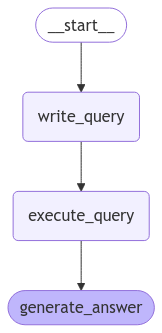

In [53]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
for step in graph.stream(
    {"question": "Show top 5 yield options for USDC"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT id, name, apy, token_symbol, provider_name\nFROM "YieldOpportunity"\nWHERE asset = \'USDC\'\nORDER BY apy DESC\nLIMIT 5;'}}
{'execute_query': {'result': "[('ethereum-usdc-bbidlecppor-usdc4626-0xa35b7a9fe5dc4cd51ba47acdf67b0f41c893329a-4626-vault', 'USDC Portofino Technologies Junior Tranches Idle Vault', 0.149, 'USDC', 'Idle Finance'), ('ethereum-usdc-aaidlecppor-usdc4626-0x291eecab3a2d3f403745968c14edbb227d183636-4626-vault', 'USDC Portofino Technologies Senior Tranches Idle Vault', 0.1152, 'USDC', 'Idle Finance'), ('base-usdc-re7usdc-0x12afdefb2237a5963e7bab3e2d46ad0eee70406e-4626-vault', 'Re7 USDC Morpho Blue Vault', 0.0905848555040482, 'USDC', 'Morpho Blue'), ('base-usdc-gtusdcc-0xc0c5689e6f4d256e861f65465b691aeecc0deb12-4626-vault', 'Gauntlet USDC Core Morpho Blue Vault', 0.0884740925836527, 'USDC', 'Morpho Blue'), ('arbitrum-usdc-dusdcv3-0x890a69ef363c9c7bdd5e36eb95ceb569f63acbf6-4626-vault', 'USDC Main USDC v3 Gearbox Vault', 0.0883, 'USDC', 'Ge